In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import annotations
from typing import Optional

Two parts of a bandit method are: the action selection rule, where we use our current estimate of action-values to decide how to act next; and the update rule, where we use our action and observed reward to update our current estimate of the action-values.

The sample-averaging approach to updating action-value estimates basically records the average reward observed when taking a particular action. This lends itself to a nice iterative update formula, where we don't need to keep every single observation in memory. 

Alternately, we can use a recency-weighted average to weight recent observations more heavily. This makes sense for non-stationary problems, where we expect that the environment is changing.

In [17]:
class Environment():
    """Environment for the k-armed bandit problem.

    Should return rewards for actions taken, where rewards are
    stochastic. 
    """
    def __init__(self, k: int, baseline: float = 0.0):
        if k <= 0:
            raise ValueError('number of actions (k) must be a positive integer.')
        self._num_actions = k
        # randomly generate bandit means
        self._means = { i: v for i,v in enumerate(np.random.randn(self._num_actions) + baseline) }
        self._stds = { i: 1.0 for i in range(self._num_actions) }
        self._opt_action = max(self._means, key=self._means.get) # ground-truth optimal action

    def __call__(self, action: int) -> float:
        """Pull a lever, get a reward."""
        # print('you rang?')
        return self._stds[action] * np.random.randn() + self._means[action]


class EnvironmentNonStationary(Environment):
    """To do"""
    def __init__(self, num_actions: int):
        super().__init__(num_actions)
    
    

class BanditMethod():
    """Base class for solving the k-armed bandit problem
    via action-value estimation.

    - Uses epsilon-greedy method to select actions.
    - Updates action-value estimate using sample-averages.
    """
    def __init__(self,
            k: int,
            epsilon: float = 0,
            optimism: float = 0
            ):
        if k <= 0:
            raise ValueError('Number of actions (k) must be a non-negative integer.')
        self._num_actions = k
        self._epsilon = epsilon
        self._q = np.zeros(k) + optimism
        self._n = np.zeros(k)

    def take_action(self, e: Environment) -> int:
        """Select an action, apply it to Environment, return reward.
        """
        if np.random.rand() > epsilon: # greedy
            arg_maxes = np.argwhere(self._q == np.amax(self._q)).flatten()
            action = np.random.choice(arg_maxes)
        else: # exploratory
            arg_not_maxes = np.argwhere(self._q != np.amax(self._q)).flatten()
            if arg_not_maxes.size > 0:
                action = np.random.choice(arg_not_maxes)
            else:
                action = 0
        self._n[action] += 1
        return action, e(action)

    def update_action_value(self,
            a: int,
            r: float,
            alpha: Optional[float] = None,
            ) -> None:
        """Update action-value estimate after taking action a and
        observing reward r. This will be different for different
        methods. This is sample-averaging.
        """
        if alpha:
            self._q[a] += alpha * (r - self._q[a])
        else:
            self._q[a] += (r - self._q[a]) / self._n[a]
        return


class UCBBandit(BanditMethod):
    def __init__(self, c: float, **kwargs):
        super().__init__(**kwargs)
        self._c = c

    def take_action(self, e: Environment, t: int) -> int:
        """Select an action, apply it to Environment, return reward.

        Uses upper-confidence-bound action selection.
        """
        
        # compute auxiliary action-values
        q_p = self._q + self._c * np.sqrt( np.log(t) / (self._n + 1e-8))
        
        # find max of this
        arg_maxes = np.argwhere(q_p == np.amax(q_p)).flatten()
        action = np.random.choice(arg_maxes)
                
        self._n[action] += 1
        return action, e(action)

class GradientBandit(BanditMethod):
    def __init__(self, alpha: float, baseline: bool = True, **kwargs):
        super().__init__(**kwargs)
        self._alpha = alpha
        self._H = np.zeros(self._num_actions) # preference fn
        self._baseline = baseline
        self._r_bar = 0.0 # mean reward seen
        self._probs = np.ones(self._num_actions) / float(self._num_actions)

    def take_action(self, e: Environment):
        """Select action based on softmax of preference function.
        """
        action = np.random.choice(range(self._num_actions), p=self._probs)
        self._n[action] += 1
        return action, e(action)

    def update_action_value(self, a: int, r: float, t: int) -> None:
        """Update action-value estimate via SGD.
        """
        if self._baseline:
            self._r_bar += ( r - self._r_bar)/t

        # update preferences
        for action in range(self._num_actions):
            if action == a:
                self._H[action] += self._alpha \
                    * (r - self._r_bar) \
                    * (1 - self._probs[action])
            else:
                self._H[action] += -self._alpha \
                    * (r - self._r_bar) \
                    * self._probs[action]
        
        # update probabilities via softmax
        probs = np.exp(self._H)
        self._probs = probs / np.sum(probs) # normalize


## Epsilon-greedy action selection

When we have a number of actions to choose from, and an estimate of "action-value", then we could easily just choose the action with the highest action-value; this is called *greedy action selection*. In order to more thoroughly explore the search space, though, it is important to make non-optimal choices, since it may be the case that a decision we didn't originally consider optimal might actually be better than our current optimum.

In [50]:
num_actions = 10
n_tests = 2000 # size of testbed
n_steps = int(1e3) # iterations

avg_rewards = np.zeros((3, n_steps))
avg_opt_action = np.zeros((3, n_steps))

for e_idx, epsilon in enumerate((0.1, 0.01, 0.)):

    n_opt = 0
    rewards = np.zeros((n_tests, n_steps))
    actions_opt = np.zeros((n_tests, n_steps))

    for i in range(n_tests): # for each test
        b = BanditMethod(k=num_actions, epsilon=epsilon, optimism=0.0)
        e = Environment(k=num_actions)
        for j in range(n_steps):
            a, r = b.take_action(e)
            if a == e._opt_action:
                actions_opt[i, j] = 1
            rewards[i, j] = r
            b.update_action_value(a, r)
    
    # record average reward trajectory
    avg_rewards[e_idx, :] = rewards.mean(axis=0)

    opt_choice = np.cumsum(actions_opt, axis=1) / np.arange(1, n_steps+1, 1)
    avg_opt_action[e_idx, :] = opt_choice.mean(axis=0)

KeyboardInterrupt: 

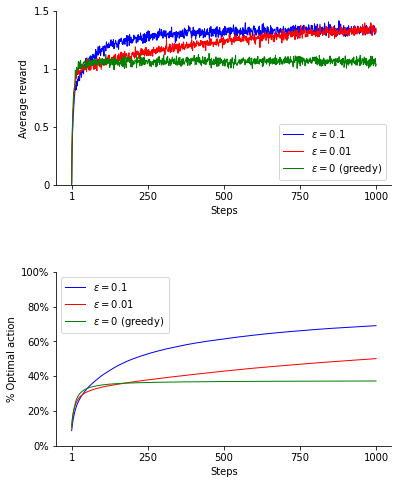

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, figsize=(6,8))
fig.subplots_adjust(hspace=.5)

ax[0].plot(avg_rewards[0,:], label=r'$\epsilon=0.1$', color='b', lw=1);
ax[0].plot(avg_rewards[1,:], label=r'$\epsilon=0.01$', color='r', lw=1);
ax[0].plot(avg_rewards[2,:], label=r'$\epsilon=0$ (greedy)', color='g', lw=1);
ax[0].set(ylabel="Average reward", xlabel="Steps", ylim=[0,1.5]);
ax[0].legend()
ax[0].set_xticks([1, 250, 500, 750, 1000])
ax[0].set_yticks([0, 0.5, 1, 1.5])
ax[0].set_yticklabels(["0", "0.5", "1", "1.5"]);
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)


ax[1].plot(avg_opt_action[0,:], label=r'$\epsilon=0.1$', color='b', lw=1);
ax[1].plot(avg_opt_action[1,:], label=r'$\epsilon=0.01$', color='r', lw=1);
ax[1].plot(avg_opt_action[2,:], label=r'$\epsilon=0$ (greedy)', color='g', lw=1);
ax[1].set(ylabel="% Optimal action", xlabel="Steps", ylim=[0,1]);
ax[1].legend()
ax[1].set_xticks([1, 250, 500, 750, 1000])
ax[1].set_yticks([0, .2, .4, .6, .8, 1.])
ax[1].set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"]);
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

## Optimism

We can initially set the action-value function to a baseline, positive constant in order to encourage exploration initially. This is called using "optimistic" initial values.

In [17]:
num_actions = 10
n_tests = 2000 # size of testbed
n_steps = int(1e3) # iterations

avg_rewards = np.zeros((2, n_steps))
avg_opt_action = np.zeros((2, n_steps))

for e_idx, optimistic in enumerate([False, True]):

    n_opt = 0
    rewards = np.zeros((n_tests, n_steps))
    actions_opt = np.zeros((n_tests, n_steps))
    
    epsilon, opt = (0.0, 5.0) if optimistic else (0.1, 0.0)

    for i in range(n_tests): # for each test

        b = BanditMethod(k=num_actions, epsilon=epsilon, optimism=opt)
        e = Environment(k=num_actions)
        for j in range(n_steps):
            a, r = b.take_action(e)
            if a == e._opt_action:
                actions_opt[i, j] = 1
            rewards[i, j] = r
            b.update_action_value(a, r, alpha=0.1)
    
    # record average reward trajectory
    avg_rewards[e_idx, :] = rewards.mean(axis=0)

    opt_choice = np.cumsum(actions_opt, axis=1) / np.arange(1, n_steps+1, 1)
    avg_opt_action[e_idx, :] = opt_choice.mean(axis=0)

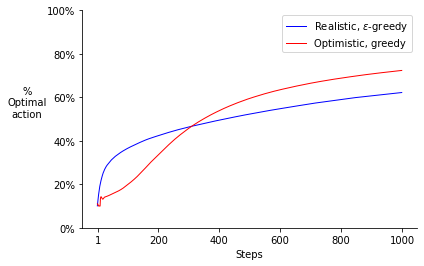

In [18]:
fig, ax = plt.subplots(nrows=1, figsize=(6,4))
fig.subplots_adjust(hspace=.5)

ax.plot(avg_opt_action[0,:], label=r'Realistic, $\epsilon$-greedy', color='b', lw=1);
ax.plot(avg_opt_action[1,:], label=r'Optimistic, greedy', color='r', lw=1);
ax.legend()
ax.set_xticks([1, 200, 400, 600, 800, 1000])
ax.set_yticks([0, .2, .4, .6, .8, 1.])
ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"]);
ax.set_ylabel(ylabel="%\nOptimal\naction", rotation=0, labelpad=20)
ax.set_xlabel(xlabel='Steps')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## UCB Action Selection

When taking a non-greedy (exploratory) action, we pick randomly among all non-greedy actions. Instead, we might try picking from the "most optimal" non-greedy actions. To do this, we want to check both how far the estimates are from optimality, plus how uncertain we are in their estimates.

$$ A_t := \argmax_{a \in \mathcal{A}_t} \left[ Q_t\left(a\right) + c \sqrt{\frac{\ln t}{N_t\left(a\right)}} \right]$$

Let's try to understand this. If the action $a$ has been seen many times before, then $N_t\left(a\right)$ will be large and so the value of the rightmost term will be small, hence we will be relatively unlikely to choose this action. Thus, this action decision tends to choose exploratory values. However, as time goes on and $t$ increases, if we don't choose $a$, $N_t\left(a\right)$ will stay constant but the numerator will grow, making it more likely that $a$ will be chosen. Of course, the estimated action-value $Q_t\left(a\right)$ is always present, so actions with larger action-values will get a sort of "baseline" preference due to the inclusion of this term.

In [58]:
num_actions = 10
n_tests = 2000 # size of testbed
n_steps = int(1e3) # iterations

avg_rewards = np.zeros((2, n_steps))
avg_opt_action = np.zeros((2, n_steps))

# UCB Bandit
e_idx = 0
n_opt = 0
rewards = np.zeros((n_tests, n_steps))
actions_opt = np.zeros((n_tests, n_steps))
    
for i in range(n_tests): # for each test
    b = UCBBandit(k=num_actions, epsilon=0.0, optimism=0.0, c=2)
    e = Environment(k=num_actions)
    for j in range(n_steps):
        a, r = b.take_action(e, t=j+1)
        if a == e._opt_action:
            actions_opt[i, j] = 1
        rewards[i, j] = r
        b.update_action_value(a, r, alpha=0.1)

# record average reward trajectory
avg_rewards[e_idx, :] = rewards.mean(axis=0)

opt_choice = np.cumsum(actions_opt, axis=1) / np.arange(1, n_steps+1, 1)
avg_opt_action[e_idx, :] = opt_choice.mean(axis=0)

# UCB Bandit
e_idx = 1
n_opt = 0
rewards = np.zeros((n_tests, n_steps))
actions_opt = np.zeros((n_tests, n_steps))
    
for i in range(n_tests): # for each test
    b = BanditMethod(k=num_actions, epsilon=0.1, optimism=0.0)
    e = Environment(k=num_actions)
    for j in range(n_steps):
        a, r = b.take_action(e)
        if a == e._opt_action:
            actions_opt[i, j] = 1
        rewards[i, j] = r
        b.update_action_value(a, r, alpha=0.1)

# record average reward trajectory
avg_rewards[e_idx, :] = rewards.mean(axis=0)

opt_choice = np.cumsum(actions_opt, axis=1) / np.arange(1, n_steps+1, 1)
avg_opt_action[e_idx, :] = opt_choice.mean(axis=0)

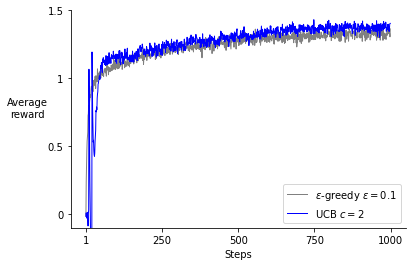

In [64]:
fig, ax = plt.subplots(nrows=1, figsize=(6,4))
fig.subplots_adjust(hspace=.5)

ax.plot(avg_rewards[1,:], label=r'$\epsilon$-greedy $\epsilon=0.1$', color='gray', lw=1);
ax.plot(avg_rewards[0,:], label=r'UCB $c=2$', color='b', lw=1);
# ax.plot(avg_opt_action[1,:], label=r'Optimistic, greedy', color='r', lw=1);
ax.legend()
ax.set_xticks([1, 250, 500, 750, 1000])
ax.set_yticks([0, .5, 1, 1.5])
ax.set_yticklabels(["0", "0.5", "1", "1.5"]);
ax.set_ylabel(ylabel="Average\nreward", rotation=0, labelpad=20)
ax.set_xlabel(xlabel='Steps')
ax.set_ylim([-0.1,1.5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Gradient Bandit Algorithms

Rather than track action-values, we record a numerical *preference* for each action, denoted $H_t\left(a\right)$. Our action decision consists of mapping this vector to a probability distribution using the softmax distribution, $$ \text{Pr}\left\{A_t=a\right\} \propto \exp\left(H_t\left(a\right)\right), $$ and then drawing an action from this distribution.

The update formula is stochastic gradient ascent on action preferences:
$$ H_{t+1}\left(A_t\right) = H_t\left(A_t\right) - \alpha \left(R_t - \bar{R}_t\right)\left(1-\pi_t\left(A_t\right)\right)$$ 
and $$ H_{t+1}\left(a\right) = H_t\left(a\right) - \alpha \left(R_t - \bar{R}_t\right) \pi_t\left(a\right)$$ 
for all $a\neq A_t$.

In [18]:
num_actions = 10
n_tests = 2000 # size of testbed
n_steps = int(1e3) # iterations

avg_rewards = np.zeros((2, n_steps))
avg_opt_action = np.zeros((2, n_steps))

# Gradient Bandit w/ baseline
e_idx = 0
n_opt = 0
rewards = np.zeros((n_tests, n_steps))
actions_opt = np.zeros((n_tests, n_steps))
    
for i in range(n_tests): # for each test
    b = GradientBandit(k=num_actions, alpha=0.1)
    e = Environment(k=num_actions)
    for j in range(n_steps):
        a, r = b.take_action(e)
        if a == e._opt_action:
            actions_opt[i, j] = 1
        rewards[i, j] = r
        b.update_action_value(a, r, t=j+1,)

# record average reward trajectory
avg_rewards[e_idx, :] = rewards.mean(axis=0)

opt_choice = np.cumsum(actions_opt, axis=1) / np.arange(1, n_steps+1, 1)
avg_opt_action[e_idx, :] = opt_choice.mean(axis=0)

# Gradient Bandit w/out baseline
e_idx = 1
n_opt = 0
rewards = np.zeros((n_tests, n_steps))
actions_opt = np.zeros((n_tests, n_steps))
    
for i in range(n_tests): # for each test
    b = GradientBandit(k=num_actions, alpha=0.1, baseline=False)
    e = Environment(k=num_actions)
    for j in range(n_steps):
        a, r = b.take_action(e)
        if a == e._opt_action:
            actions_opt[i, j] = 1
        rewards[i, j] = r
        b.update_action_value(a, r, t=j+1,)

# record average reward trajectory
avg_rewards[e_idx, :] = rewards.mean(axis=0)

opt_choice = np.cumsum(actions_opt, axis=1) / np.arange(1, n_steps+1, 1)
avg_opt_action[e_idx, :] = opt_choice.mean(axis=0)

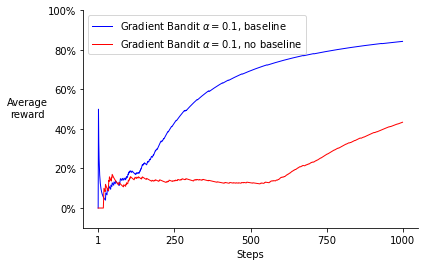

In [20]:
fig, ax = plt.subplots(nrows=1, figsize=(6,4))
fig.subplots_adjust(hspace=.5)

ax.plot(opt_choice[0,:], label=r'Gradient Bandit $\alpha=0.1$, baseline', color='blue', lw=1);
ax.plot(opt_choice[1,:], label=r'Gradient Bandit $\alpha=0.1$, no baseline', color='red', lw=1);
# ax.plot(avg_rewards[0,:], label=r'UCB $c=2$', color='b', lw=1);
# ax.plot(avg_opt_action[1,:], label=r'Optimistic, greedy', color='r', lw=1);
ax.legend()
ax.set_xticks([1, 250, 500, 750, 1000])
ax.set_yticks([0, .2, .4, .6, .8, 1.])
ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"]);
ax.set_ylabel(ylabel="Average\nreward", rotation=0, labelpad=20)
ax.set_xlabel(xlabel='Steps')
ax.set_ylim([-0.1,1.])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

This doesn't look quite right, but the performance of the method without the baseline term is definitely worse than if we include the baseline.

## Questions

* Why is this a "reinforcement learning" problem? Couldn't we just collect a set of observations and take the averages in a batch sense? Technically yes, but the bandit problem becomes interesting when we explicitly consider the time component: we want the model/agent to adapt its estimation of the environment over time, i.e., over a sequence of observations.

* This seems to apply to infinite-horizon cases where we have an unlimited amount of time to sample and understand action-values. This kind of explains why it doesn't work well in non-stationary problems. What if we have a finite-horizon case, where we have only a finite number of steps, and we want to make the most optimal decisions before we run out of time? For example, what if we have two levers, and from the first level we have many $ >> 2 $ pulls and have a sample average of $\mu_1$; from the second lever we have only 2 pulls, but a sample average of $\mu_2 > \mu_1$. Then if we have only one lever pull left, which lever should we pull?